In [4]:
import pandas as pd
import polars as pl
import json
import matplotlib.pyplot as plt
import data_analysis as dan

## Load the relevant data

In [5]:
# Load the investmetment universe data with SIC codes
data, labels = dan.load_data(display_info=False, return_labels=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359250 entries, 0 to 359249
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   gvkey          359250 non-null  int64  
 1   iid            359250 non-null  int64  
 2   id             359250 non-null  object 
 3   date           359250 non-null  int64  
 4   tic            359250 non-null  object 
 5   conm           359250 non-null  object 
 6   market_equity  358921 non-null  float64
 7   dolvol_126d    356699 non-null  float64
 8   turnover_126d  356385 non-null  float64
 9   ivol_ff3_21d   350588 non-null  float64
 10  ni_ivol        313939 non-null  float64
 11  beta_60m       318690 non-null  float64
 12  z_score        313432 non-null  float64
 13  f_score        301038 non-null  float64
 14  netdebt_me     357432 non-null  float64
 15  rd_sale        183690 non-null  float64
 16  ebit_bev       340600 non-null  float64
 17  ebit_sale      351389 non-nul

In [7]:
# Retrieve the labels
identifiers, acc_ratios, stock_chars, option_chars, txt_features, targets, all_chars = labels['identifiers'], labels['acc_ratios'], labels['stock_chars'], labels['option_chars'], labels['txt_features'], labels['targets'], labels['all_chars']

In [8]:
mkt_ind = dan.load_mkt_ind(return_rf=True)

## Load the harvested feature labels

In [9]:
# Collect the number of data points per security
data_point_counts = dan.load_data_point_counts(data)
data_point_counts

,conm,n_data,tic,min_date,max_date
0,ISABELLA BANK CORP,245,ISBA,20050228,20250630
1,EAGLE FINANCIAL SERVICES INC,245,EFSI,20050228,20250630
2,FOOT LOCKER INC,244,FL,20050228,20250630
3,H2O AMERICA,244,HTO,20050228,20250630
4,HANOVER INSURANCE GROUP INC,244,THG,20050228,20250630
...,...,...,...,...,...
1995,BRANDYWINE REALTY TRUST,5,BDN,20250228,20250630
1996,BRIGHTSPIRE CAPITAL INC,5,BRSP,20250228,20250630
1997,KITE REALTY GROUP TRUST,5,KRG,20250228,20250630
1998,SUN COMMUNITIES INC,5,SUI,20250228,20250630


In [10]:
data_point_counts.tic.nunique() 

2000

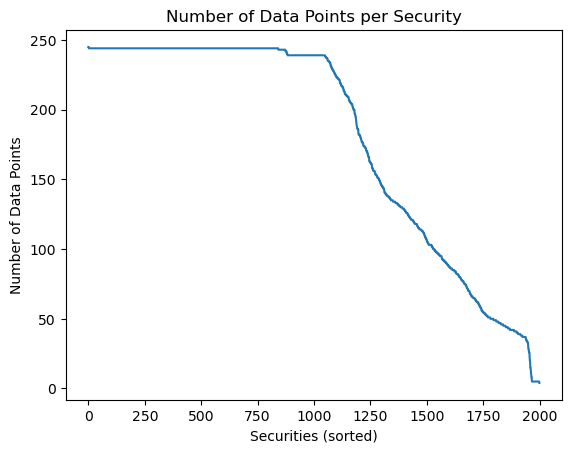

In [11]:
plt.plot(data_point_counts.n_data)
plt.title('Number of Data Points per Security')
plt.ylabel('Number of Data Points')
plt.xlabel('Securities (sorted)')
plt.show()

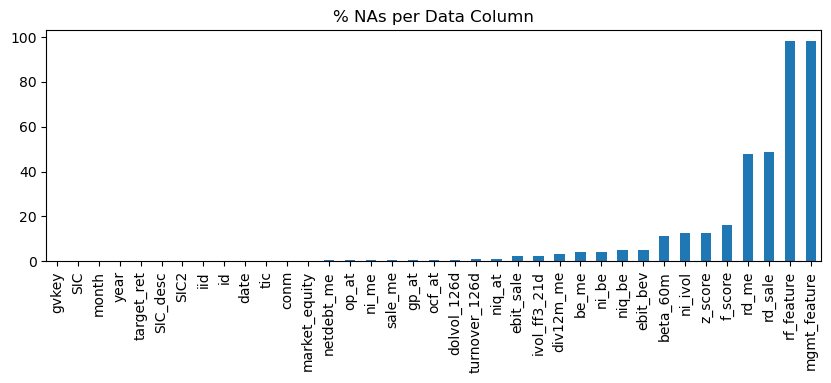

In [14]:
dan.display_na_counts(data, display_by_char=False)

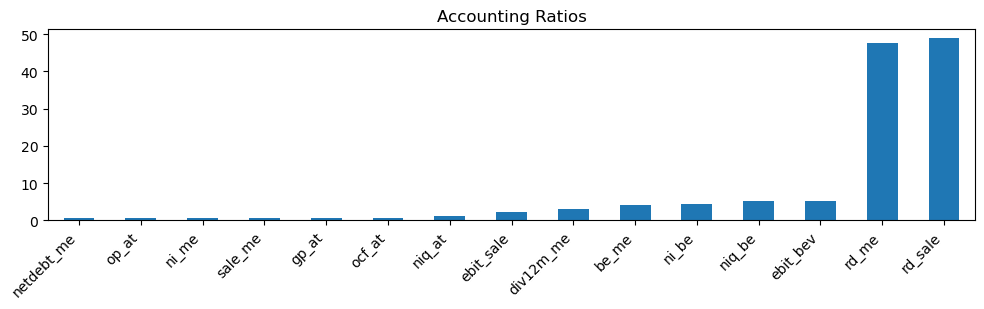

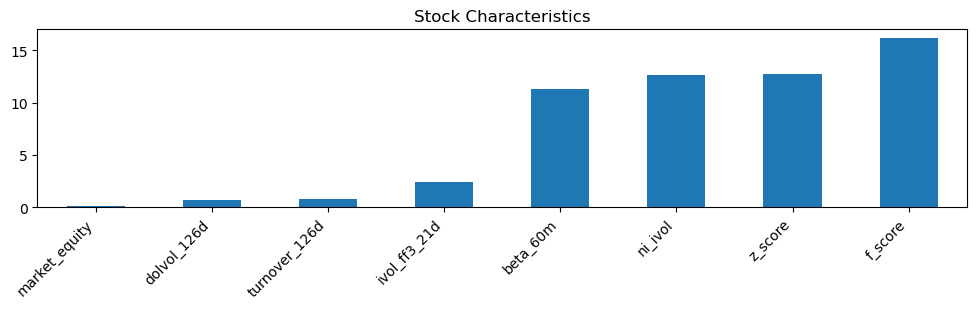

In [10]:
display_na_counts(data, display_by_char=True)

## Exclude data with many NAs for a preliminary training pipeline

In [15]:
acc_ratios.remove('rd_me')  # investigate whether can be redeemed
acc_ratios.remove('rd_sale') 

# Excluded from the model
print(f"Data not included in the model: {set(data.columns) - set(identifiers + stock_chars + acc_ratios + targets )}")
print(f"Data Shape: {data.shape}")
print(f"Data Shape (after dropping NAs): {data.dropna().shape}")
print(f"Data Shape (after dropping most_na cols): {data[stock_chars + acc_ratios + targets].dropna().shape}")

Data not included in the model: {'SIC_desc', 'mgmt_feature', 'rd_sale', 'SIC', 'rd_me', 'rf_feature', 'id'}
Data Shape: (359250, 37)
Data Shape (after dropping NAs): (2622, 37)
Data Shape (after dropping most_na cols): (247593, 22)


In [16]:
# Consider including the market index data.
# Compute excess returns
ml_data = data[identifiers + stock_chars + acc_ratios + targets].dropna().drop(['gvkey', 'iid'], axis=1)
ml_data = (
        ml_data.merge(mkt_ind[['year','month', 'rf']], on=['month', 'year'], how='left')
        .assign(target_exret = lambda df: df['target_ret'] - df['rf'])
        .assign(SIC2 = lambda df: df['SIC2'].astype(int).astype(str).str.zfill(2))
        .drop(['target_ret', 'rf'], axis=1)
)
ml_data.head()

,date,year,month,tic,conm,SIC2,market_equity,dolvol_126d,turnover_126d,ivol_ff3_21d,...,niq_be,ocf_at,gp_at,niq_at,op_at,be_me,div12m_me,ni_me,sale_me,target_exret
0,20050228,2005,2,JJSF,J & J SNACK FOODS CORP,20,436.469500,1.027584e+06,0.002604,0.024580,...,0.041494,0.169935,0.590511,0.033460,0.211968,0.525235,0.002584,0.052031,0.954449,-0.023154
1,20050228,2005,2,PLXS,PLEXUS CORP,36,497.652500,5.409342e+06,0.010524,0.025420,...,-0.095016,-0.039127,0.205654,-0.064130,0.080571,0.706141,0.000000,-0.063458,2.091536,-0.081461
2,20050228,2005,2,MSFT,MICROSOFT CORP,73,285932.241630,5.725156e+08,0.006475,0.005927,...,0.033785,0.161338,0.341675,0.027363,0.224901,0.265608,0.120160,0.028265,0.132231,-0.041174
3,20050228,2005,2,RGEN,REPLIGEN CORP,28,69.170199,3.639339e+05,0.005309,0.041756,...,-0.064646,-0.134410,0.183160,-0.059221,0.038262,0.359664,0.000000,-0.111999,0.109006,-0.214643
4,20050228,2005,2,DLHC,DLH HOLDINGS CORP,73,30.689669,3.179099e+04,0.000900,0.033386,...,-0.004581,-0.031874,0.233589,-0.003668,-0.070213,1.009884,0.000000,-0.057511,1.215002,-0.034048


In [17]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247593 entries, 0 to 247592
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           247593 non-null  int64  
 1   year           247593 non-null  int64  
 2   month          247593 non-null  int64  
 3   tic            247593 non-null  object 
 4   conm           247593 non-null  object 
 5   SIC2           247593 non-null  object 
 6   market_equity  247593 non-null  float64
 7   dolvol_126d    247593 non-null  float64
 8   turnover_126d  247593 non-null  float64
 9   ivol_ff3_21d   247593 non-null  float64
 10  ni_ivol        247593 non-null  float64
 11  beta_60m       247593 non-null  float64
 12  z_score        247593 non-null  float64
 13  f_score        247593 non-null  float64
 14  netdebt_me     247593 non-null  float64
 15  ebit_bev       247593 non-null  float64
 16  ebit_sale      247593 non-null  float64
 17  ni_be          247593 non-nul

In [18]:
tic_classes = dan.load_gics_ticker_classes()

In [19]:
ml_data  = (ml_data.merge(tic_classes[['SIC2','sector','subsector']], 
            on='SIC2', how='left')
        .drop('SIC2', axis=1)
        

)

# put 'sector' and 'subsector' right after 'conm'
pos = ml_data.columns.get_loc('conm') + 1
ml_data.insert(pos,   'sector',    ml_data.pop('sector'))
ml_data.insert(pos+1, 'subsector', ml_data.pop('subsector'))

In [20]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247593 entries, 0 to 247592
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           247593 non-null  int64  
 1   year           247593 non-null  int64  
 2   month          247593 non-null  int64  
 3   tic            247593 non-null  object 
 4   conm           247593 non-null  object 
 5   sector         247593 non-null  object 
 6   subsector      247593 non-null  object 
 7   market_equity  247593 non-null  float64
 8   dolvol_126d    247593 non-null  float64
 9   turnover_126d  247593 non-null  float64
 10  ivol_ff3_21d   247593 non-null  float64
 11  ni_ivol        247593 non-null  float64
 12  beta_60m       247593 non-null  float64
 13  z_score        247593 non-null  float64
 14  f_score        247593 non-null  float64
 15  netdebt_me     247593 non-null  float64
 16  ebit_bev       247593 non-null  float64
 17  ebit_sale      247593 non-nul

In [34]:
pl.from_dataframe(ml_data).write_csv('../data/ml_data_panel.csv')

## EDA

In [21]:
ml_data.head()

,date,year,month,tic,conm,sector,subsector,market_equity,dolvol_126d,turnover_126d,...,niq_be,ocf_at,gp_at,niq_at,op_at,be_me,div12m_me,ni_me,sale_me,target_exret
0,20050228,2005,2,JJSF,J & J SNACK FOODS CORP,Consumer Staples,Food & Kindred Products,436.469500,1.027584e+06,0.002604,...,0.041494,0.169935,0.590511,0.033460,0.211968,0.525235,0.002584,0.052031,0.954449,-0.023154
1,20050228,2005,2,PLXS,PLEXUS CORP,Information Technology,Electronic & Other Electrical (incl. 367 semis),497.652500,5.409342e+06,0.010524,...,-0.095016,-0.039127,0.205654,-0.064130,0.080571,0.706141,0.000000,-0.063458,2.091536,-0.081461
2,20050228,2005,2,MSFT,MICROSOFT CORP,Information Technology,"Business Services (incl. computer programming,...",285932.241630,5.725156e+08,0.006475,...,0.033785,0.161338,0.341675,0.027363,0.224901,0.265608,0.120160,0.028265,0.132231,-0.041174
3,20050228,2005,2,RGEN,REPLIGEN CORP,Materials,Chemicals & Allied,69.170199,3.639339e+05,0.005309,...,-0.064646,-0.134410,0.183160,-0.059221,0.038262,0.359664,0.000000,-0.111999,0.109006,-0.214643
4,20050228,2005,2,DLHC,DLH HOLDINGS CORP,Information Technology,"Business Services (incl. computer programming,...",30.689669,3.179099e+04,0.000900,...,-0.004581,-0.031874,0.233589,-0.003668,-0.070213,1.009884,0.000000,-0.057511,1.215002,-0.034048


In [22]:
dan.load_data_point_counts(ml_data)

,conm,n_data,tic,min_date,max_date
0,IDEX CORP,239,IEX,20050228,20241231
1,J & J SNACK FOODS CORP,239,JJSF,20050228,20241231
2,INTEL CORP,239,INTC,20050228,20241231
3,INTERFACE INC,239,TILE,20050228,20241231
4,INTERPARFUMS INC,239,IPAR,20050228,20241231
...,...,...,...,...,...
1563,KARAT PACKAGING INC,3,KRT,20240531,20240731
1564,PROCORE TECHNOLGY INC,2,PCOR,20240628,20240731
1565,BEAM THERAPEUTICS INC,2,BEAM,20241129,20241231
1566,IOVANCE BIOTHERAPEUTICS INC,2,IOVA,20241129,20241231


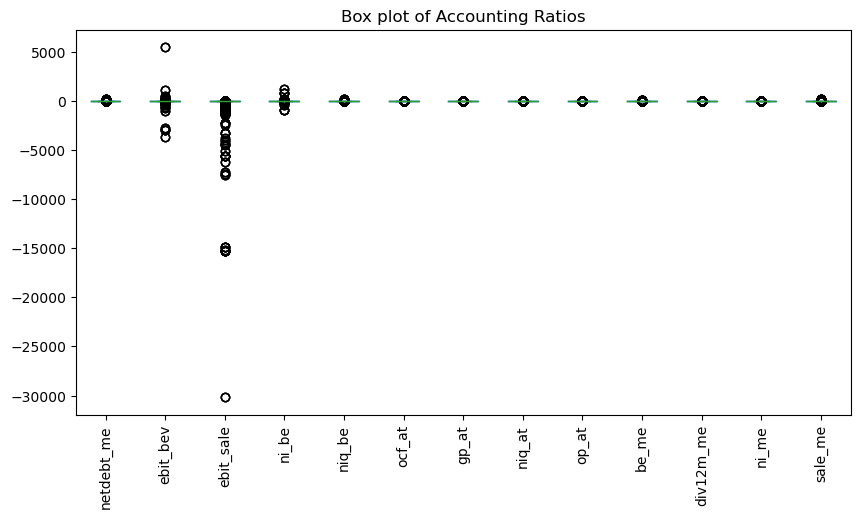

In [23]:
ml_data[acc_ratios].plot(kind='box', figsize=(10,5), title='Box plot of Accounting Ratios', rot=90)
plt.show()

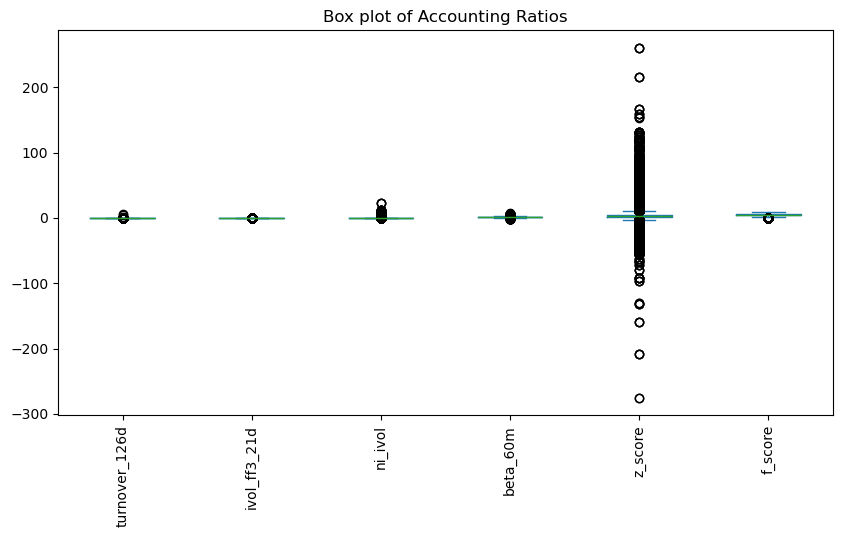

In [24]:
ml_data[stock_chars].drop(['dolvol_126d', 'market_equity'], axis=1).plot(kind='box', figsize=(10,5), title='Box plot of Accounting Ratios', rot=90)
plt.show()

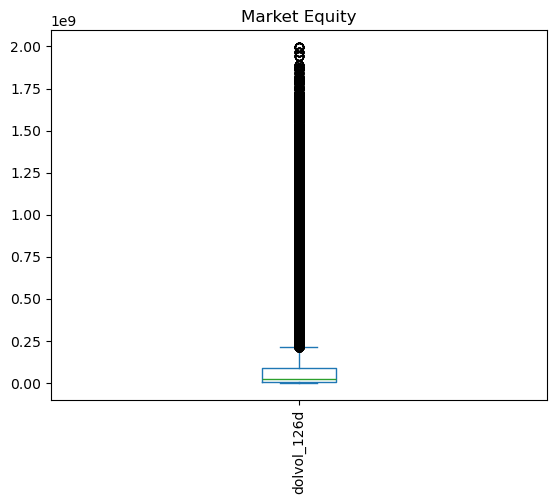

In [ ]:
ml_data[['dolvol_126d']].plot(kind='box', title='Box plot of Dollar Volume', rot=90)
plt.show()

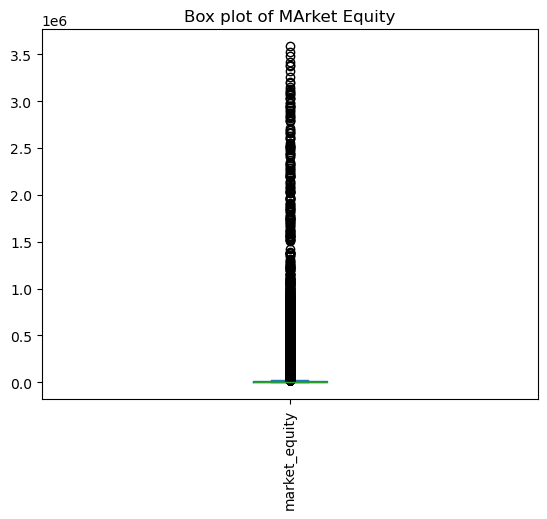

In [29]:
ml_data[['market_equity']].plot(kind='box', title='Box plot of MArket Equity', rot=90)
plt.show()

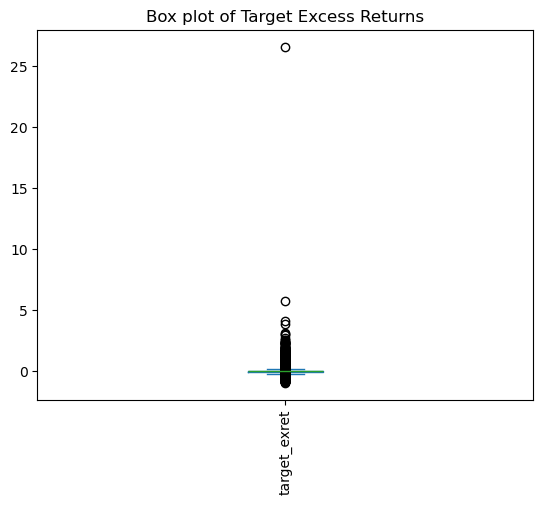

In [31]:
ml_data[['target_exret']].plot(kind='box', title='Box plot of Target Excess Returns', rot=90)
plt.show()

In [36]:
(tic_classes.drop(['SIC2', 'SIC2_descrip'], axis=1).loc[:,
    ['n_data', 'sector', 'subsector', 'n_tics', 'tics', 'conm', 'min_date', 'max_date',
        ]]
    .sort_values(by='n_data', ascending=False)
    .reset_index(drop=True)
)                                             

,n_data,sector,subsector,n_tics,tics,conm,min_date,max_date
0,37018,Materials,Chemicals & Allied,250,"[RGEN, BCPC, AVD, IPAR, OLN, AMGN, PG, CL, FMC...","[REPLIGEN CORP, BALCHEM CORP -CL B, AMERICAN ...",20050228,20250630
1,34181,Financials,Depository Institutions,157,"[BHRB, CHMG, ALRS, FMBH, MOFG, LCNB, ORRF, BFC...","[BURKE HERBERT FINL SRVS CORP, CHEMUNG FINANCI...",20050228,20250630
2,32106,Information Technology,"Business Services (incl. computer programming,...",228,"[TRAK, XTIA, MSFT, DLHC, FI, UIS, CDNS, FICO, ...","[REPOSITRAK INC, XTI AEROSPACE INC, MICROSOFT ...",20050228,20250630
3,21608,Information Technology,Electronic & Other Electrical (incl. 367 semis),120,"[PLXS, GE, AMAT, TXN, MSI, WHR, CTS, HUBB, FEL...","[PLEXUS CORP, GE AEROSPACE, APPLIED MATERIALS ...",20050228,20250630
4,20507,Information Technology,Instruments (med/optical/scientific—often IT/H...,115,"[OSUR, CNMD, XRAY, TT, MMM, NOC, LHX, BAX, COH...","[ORASURE TECHNOLOGIES INC, CONMED CORP, DENTSP...",20050228,20250630
...,...,...,...,...,...,...,...,...
62,254,Energy,Pipelines (except natural gas),3,"[DINO, PAGP, PAA]","[HF SINCLAIR CORP, PLAINS GP HOLDINGS LP, PLAI...",20050228,20250630
63,244,Consumer Staples,Agricultural Production – Livestock,1,[CALM],[CAL-MAINE FOODS INC],20050228,20250630
64,244,Industrials,Legal Services,1,[CRAI],[CRA INTERNATIONAL INC],20050228,20250630
65,244,Industrials,Services Not Elsewhere Classified,1,[NVRI],[ENVIRI CORP],20050228,20250630


In [50]:
sectors, subsectors = dan.bin_tics_by_gics()

In [121]:
sectors

,sector,n_subsector,subsectors,tics,n_tics
0,Information Technology,4,[Business Services (incl. computer programming...,"[A, AAOI, AAON, AAPL, ACIW, ADBE, ADI, ADN, AD...",554
1,Materials,9,"[Chemicals & Allied, Fabricated Metal Products...","[AA, ABT, ACA, ACAD, ACU, ADPT, AGEN, AGIO, AK...",363
2,Financials,6,"[Depository Institutions, Holding & Investment...","[AAMI, ABCB, ABL, ACGL, ACT, AFG, AFL, AGM, AG...",356
3,Industrials,16,"[Air Transportation, Building Construction, Co...","[AAL, ACHR, ADNT, AIR, ALGT, ALK, ALSN, ALTG, ...",230
4,Consumer Discretionary,16,"[Amusement & Recreation, Apparel & Accessory S...","[AAP, ABG, AEO, AIN, AMZN, AN, ANF, APEI, ASO,...",198
5,Utilities,1,"[Electric, Gas & Sanitary Services]","[AEE, AEP, AES, ALE, AM, AROC, AWK, BKH, CLH, ...",75
6,Energy,4,"[Coal Mining, Oil & Gas Extraction, Petroleum ...","[AESI, AMR, APA, AR, ARIS, BRY, CHRD, CIVI, CN...",70
7,Communication Services,3,"[Communications, Motion Pictures (media/entert...","[ACCO, AD, AMC, AMCX, AREN, ASTS, ATEX, ATNI, ...",52
8,Consumer Staples,6,"[Agricultural Production – Crops, Agricultural...","[ADM, ARKO, BGS, BV, CAG, CALM, CELH, COCO, CO...",50
9,Health Care,1,[Health Services],"[ACHC, ADUS, AHCO, AONC, BKD, CHE, CSTL, CYH, ...",30


In [52]:
subsectors

,subsector,sector,tics,n_tics
0,Chemicals & Allied,Materials,"[ABT, ACAD, ADPT, AGEN, AGIO, AKRO, ALB, ALEC,...",250
1,"Business Services (incl. computer programming,...",Information Technology,"[ACIW, ADBE, ADP, ADSK, ADT, AGYS, AI, AISP, A...",228
2,Depository Institutions,Financials,"[ABCB, ALLY, ALRS, ASB, AUB, AX, BAC, BANC, BA...",157
3,Electronic & Other Electrical (incl. 367 semis),Information Technology,"[AAOI, ADI, ADN, ADTN, AEIS, ALGM, AMAT, AMBA,...",120
4,Instruments (med/optical/scientific—often IT/H...,Information Technology,"[A, ALGN, ALNT, AME, ANGO, ANIK, AORT, ARAY, A...",115
...,...,...,...,...
62,Agricultural Production – Crops,Consumer Staples,"[CTVA, FDP]",2
63,"Social Services (e.g. child day care, communit...",Consumer Discretionary,[BFAM],1
64,Services Not Elsewhere Classified,Industrials,[NVRI],1
65,Legal Services,Industrials,[CRAI],1


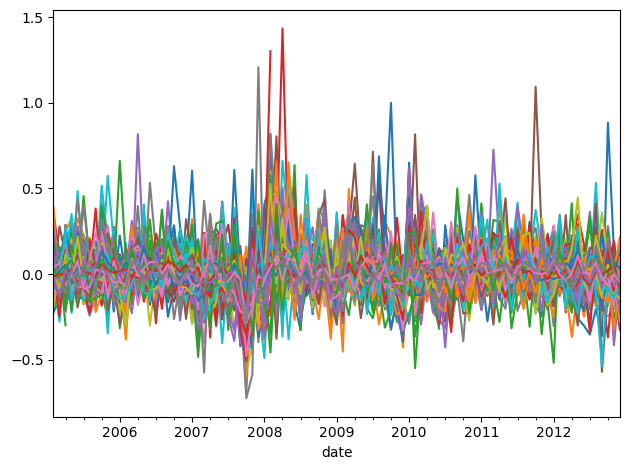

In [117]:
(ml_data
    .loc[ml_data.tic.isin(sectors.loc[sectors['sector']=='Information Technology'].tics[0])]
    .loc[:, ['date', 'tic', 'target_exret']]
    .assign(date = pd.to_datetime(data[['year','month']].assign(DAY=1)) + pd.offsets.MonthEnd(0))
    .query("'2005-01-01' <= date <= '2012-12-31'")
    .reset_index(drop=True)
    .pivot_table(index='date', columns='tic', values='target_exret')
            .sort_index()
    .plot(legend=False)
    )

plt.tight_layout(); plt.show()

### Screen and Filter

In [125]:
ml_data

,date,year,month,tic,conm,sector,subsector,market_equity,dolvol_126d,turnover_126d,...,niq_be,ocf_at,gp_at,niq_at,op_at,be_me,div12m_me,ni_me,sale_me,target_exret
0,20050228,2005,2,JJSF,J & J SNACK FOODS CORP,Consumer Staples,Food & Kindred Products,4.364695e+02,1.027584e+06,0.002604,...,0.041494,0.169935,0.590511,0.033460,0.211968,0.525235,0.002584,0.052031,0.954449,-0.023154
1,20050228,2005,2,PLXS,PLEXUS CORP,Information Technology,Electronic & Other Electrical (incl. 367 semis),4.976525e+02,5.409342e+06,0.010524,...,-0.095016,-0.039127,0.205654,-0.064130,0.080571,0.706141,0.000000,-0.063458,2.091536,-0.081461
2,20050228,2005,2,MSFT,MICROSOFT CORP,Information Technology,"Business Services (incl. computer programming,...",2.859322e+05,5.725156e+08,0.006475,...,0.033785,0.161338,0.341675,0.027363,0.224901,0.265608,0.120160,0.028265,0.132231,-0.041174
3,20050228,2005,2,RGEN,REPLIGEN CORP,Materials,Chemicals & Allied,6.917020e+01,3.639339e+05,0.005309,...,-0.064646,-0.134410,0.183160,-0.059221,0.038262,0.359664,0.000000,-0.111999,0.109006,-0.214643
4,20050228,2005,2,DLHC,DLH HOLDINGS CORP,Information Technology,"Business Services (incl. computer programming,...",3.068967e+01,3.179099e+04,0.000900,...,-0.004581,-0.031874,0.233589,-0.003668,-0.070213,1.009884,0.000000,-0.057511,1.215002,-0.034048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247588,20241231,2024,12,SPSC,SPS COMMERCE INC,Information Technology,"Business Services (incl. computer programming,...",7.253254e+03,3.664191e+07,0.005164,...,0.026114,0.163991,0.473307,0.021471,0.206998,0.097947,0.000000,0.009911,0.080488,-0.050730
247589,20241231,2024,12,PLOW,DOUGLAS DYNAMICS INC,Information Technology,Industrial/Computer Machinery (incl. 357),5.979036e+02,4.998834e+06,0.008427,...,0.099275,0.096572,0.247906,0.042175,0.123704,0.442073,0.045469,0.048260,0.959892,-0.079598
247590,20241231,2024,12,VPG,VISHAY PRECISION GROUP INC,Information Technology,Electronic & Other Electrical (incl. 367 semis),2.806015e+02,2.024922e+06,0.006262,...,0.013891,0.089784,0.341108,0.009873,0.110314,1.177898,0.000000,0.074843,1.188604,0.018068
247591,20241231,2024,12,FN,FABRINET,Information Technology,Electronic & Other Electrical (incl. 367 semis),8.507748e+03,1.266155e+08,0.014753,...,0.048692,0.176670,0.173244,0.036238,0.139684,0.205770,0.000000,0.034813,0.338864,-0.066365


In [120]:
ml_data.head().to_dict()

{'date': {0: 20050228, 1: 20050228, 2: 20050228, 3: 20050228, 4: 20050228},
 'year': {0: 2005, 1: 2005, 2: 2005, 3: 2005, 4: 2005},
 'month': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2},
 'tic': {0: 'JJSF', 1: 'PLXS', 2: 'MSFT', 3: 'RGEN', 4: 'DLHC'},
 'conm': {0: 'J & J SNACK FOODS CORP',
  1: 'PLEXUS CORP',
  2: 'MICROSOFT CORP',
  3: 'REPLIGEN CORP',
  4: 'DLH HOLDINGS CORP'},
 'sector': {0: 'Consumer Staples',
  1: 'Information Technology',
  2: 'Information Technology',
  3: 'Materials',
  4: 'Information Technology'},
 'subsector': {0: 'Food & Kindred Products',
  1: 'Electronic & Other Electrical (incl. 367 semis)',
  2: 'Business Services (incl. computer programming, data processing, software)',
  3: 'Chemicals & Allied',
  4: 'Business Services (incl. computer programming, data processing, software)'},
 'market_equity': {0: 436.4695,
  1: 497.65249977,
  2: 285932.24163,
  3: 69.170198566,
  4: 30.689668791},
 'dolvol_126d': {0: 1027583.67241392,
  1: 5409342.42332304,
  2: 572515632.58461